In [4]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set your save/load paths
import os

SAVE_DIR = '/content/drive/MyDrive/covid_project_checkpoints'
os.makedirs(SAVE_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# %% [markdown]
### COVID-19 Chest X-Ray EDA
# **Important Insight**: This dataset lacks severity labels (only binary COVID/non-COVID). Severity scoring requires additional datasets with clinical annotations.
# Steps:
# 1. Download dataset from Kaggle
# 2. Analyze class distribution
# 3. Inspect image characteristics
# 4. Visualize samples
# 5. Discuss severity scoring strategy

# %% [code]
# Install Kaggle API
!pip install -q kaggle
from google.colab import files

# Upload Kaggle API key (download from https://www.kaggle.com/settings)
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# %% [code]
# Download and unzip dataset
!kaggle datasets download -d anasmohammedtahir/covidqu
!unzip -q covidqu.zip -d covidqu_data
!rm covidqu.zip

# %% [code]
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter


#    ```

Dataset URL: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu
License(s): CC-BY-SA-4.0
User cancelled operation
unzip:  cannot find or open covidqu.zip, covidqu.zip.zip or covidqu.zip.ZIP.
rm: cannot remove 'covidqu.zip': No such file or directory


In [10]:
# Based on the actual structure, let's modify our paths
import os

# Check what's inside the main directory
base_path = 'covidqu_data'
print("Root directory contents:", os.listdir(base_path))

Root directory contents: ['Lung Segmentation Data', 'COVID-QU-Ex dataset.txt', 'Infection Segmentation Data']


In [11]:
# Base paths
base_path = 'covidqu_data'
lung_base = os.path.join(base_path, 'Lung Segmentation Data', 'Lung Segmentation Data')
infection_base = os.path.join(base_path, 'Infection Segmentation Data', 'Infection Segmentation Data')

# %% [code]
# 1. Analyze dataset structure
def analyze_structure(path):
    print(f"\nStructure of {path}:")
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files[:5]:  # Print first 5 files only
            print(f"{subindent}{f}")
        if len(files) > 5:
            print(f"{subindent}...{len(files)-5} more files")

analyze_structure(lung_base)
analyze_structure(infection_base)

# %% [code]
# 2. Create dataframe with all image paths and labels
def build_dataset_df(base_path):
    data = []
    for subset in ['Train', 'Test', 'Val']:
        for class_name in ['COVID-19', 'Non-COVID', 'Normal']:
            # Original images
            img_dir = os.path.join(base_path, subset, class_name, 'images')
            if os.path.exists(img_dir):
                for img_file in os.listdir(img_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            'subset': subset,
                            'class': class_name,
                            'type': 'original',
                            'path': os.path.join(img_dir, img_file)
                        })

            # Lung masks
            lung_mask_dir = os.path.join(base_path, subset, class_name, 'lung masks')
            if os.path.exists(lung_mask_dir):
                for mask_file in os.listdir(lung_mask_dir):
                    if mask_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            'subset': subset,
                            'class': class_name,
                            'type': 'lung_mask',
                            'path': os.path.join(lung_mask_dir, mask_file)
                        })

    return pd.DataFrame(data)

# Create dataframes for both segmentation types
lung_df = build_dataset_df(lung_base)
infection_df = build_dataset_df(infection_base)

print("\nLung Data Summary:")
print(lung_df.groupby(['subset', 'class', 'type']).size().unstack())

print("\nInfection Data Summary:")
print(infection_df.groupby(['subset', 'class', 'type']).size().unstack())

# %% [code]
# 3. Merge the dataframes to create complete samples
# First ensure we can match files between the two datasets
def extract_base_filename(path):
    """Extract comparable filename from path"""
    filename = os.path.basename(path)
    # Remove possible prefixes/suffixes
    for s in ['_lung_mask', '_infection', '_mask']:
        filename = filename.replace(s, '')
    return filename

# Create matching keys
lung_df['match_key'] = lung_df['path'].apply(extract_base_filename)
infection_df['match_key'] = infection_df['path'].apply(extract_base_filename)

# Merge the dataframes
merged_df = pd.merge(
    lung_df[lung_df['type'] == 'original'],
    lung_df[lung_df['type'] == 'lung_mask'],
    on=['subset', 'class', 'match_key'],
    suffixes=('_original', '_lung_mask')
)

merged_df = pd.merge(
    merged_df,
    infection_df[infection_df['type'] == 'lung_mask'],
    on=['subset', 'class', 'match_key']
)

# Clean up column names
merged_df = merged_df.rename(columns={
    'path': 'infection_mask_path',
    'type': 'infection_mask_type'
})
merged_df = merged_df[[
    'subset', 'class', 'match_key',
    'path_original', 'path_lung_mask', 'infection_mask_path'
]]

print("\nMerged dataset samples:")
print(merged_df.head())

# %% [code]
# 4. Calculate severity scores
def calculate_severity(row):
    try:
        lung_mask = cv2.imread(row['path_lung_mask'], cv2.IMREAD_GRAYSCALE)
        infection_mask = cv2.imread(row['infection_mask_path'], cv2.IMREAD_GRAYSCALE)

        if lung_mask is None or infection_mask is None:
            return np.nan

        # Calculate areas
        lung_area = np.sum(lung_mask > 127)
        infection_area = np.sum(infection_mask > 127)

        return (infection_area / lung_area) * 100 if lung_area > 0 else 0
    except:
        return np.nan

merged_df['severity'] = merged_df.apply(calculate_severity, axis=1)

# Remove rows with missing severity scores
merged_df = merged_df.dropna(subset=['severity'])

print("\nSeverity statistics by class:")
print(merged_df.groupby('class')['severity'].describe())

# %% [code]
# 5. Visualize samples
def visualize_sample(row):
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 4, 1)
    img = cv2.imread(row['path_original'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Original\n{row['class']}")  # Fixed: using row['class'] instead of undefined class
    plt.axis('off')

    # Lung mask
    plt.subplot(1, 4, 2)
    lung_mask = cv2.imread(row['path_lung_mask'], cv2.IMREAD_GRAYSCALE)
    plt.imshow(lung_mask, cmap='gray')
    plt.title("Lung Mask")
    plt.axis('off')

    # Infection mask
    plt.subplot(1, 4, 3)
    infection_mask = cv2.imread(row['infection_mask_path'], cv2.IMREAD_GRAYSCALE)
    plt.imshow(infection_mask, cmap='hot')
    plt.title("Infection Mask")
    plt.axis('off')

    # Combined
    plt.subplot(1, 4, 4)
    overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 0.7, infection_mask, 0.3, 0)
    plt.imshow(overlay, cmap='viridis')
    plt.title(f"Severity: {row['severity']:.2f}%")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize random samples for each class
for class_name in merged_df['class'].unique():
    print(f"\nVisualizing random {class_name} sample:")
    sample = merged_df[merged_df['class'] == class_name].sample(1).iloc[0]
    visualize_sample(sample)



### Next Steps
def preprocess_image(img_path, target_size=(512, 512)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img / 255.0  # Normalize


Structure of covidqu_data/Lung Segmentation Data/Lung Segmentation Data:
Lung Segmentation Data/
    Train/
        COVID-19/
            lung masks/
                sub-S10123_ses-E17439_run-1_bp-chest_vp-ap_dx.png
                covid_4257.png
                sub-S11384_ses-E23447_acq-1_run-1_bp-chest_vp-ll_dx.png
                sub-S11577_ses-E21315_run-1_bp-chest_vp-ap_cr.png
                covid_4387.png
                ...7653 more files
            images/
                sub-S10123_ses-E17439_run-1_bp-chest_vp-ap_dx.png
                covid_4257.png
                sub-S11384_ses-E23447_acq-1_run-1_bp-chest_vp-ll_dx.png
                sub-S11577_ses-E21315_run-1_bp-chest_vp-ap_cr.png
                covid_4387.png
                ...7653 more files
        Non-COVID/
            lung masks/
                non_COVID (827).png
                non_COVID (1190).png
                non_COVID (10550).png
                non_COVID (6679).png
                non_COVID (7563).png

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set root paths
lung_root = 'covidqu_data/Lung Segmentation Data/Lung Segmentation Data'
infection_root = 'covidqu_data/Infection Segmentation Data/Infection Segmentation Data'

# Function to count files per class/category
def count_files(root_dir, has_infection_masks=False):
    records = []
    for split in ['Train', 'Val', 'Test']:
        for cls in ['Normal', 'Non-COVID', 'COVID-19']:
            image_dir = os.path.join(root_dir, split, cls, 'images')
            lung_mask_dir = os.path.join(root_dir, split, cls, 'lung masks')
            inf_mask_dir = os.path.join(root_dir, split, cls, 'infection masks') if has_infection_masks else None

            image_count = len(os.listdir(image_dir)) if os.path.exists(image_dir) else 0
            lung_mask_count = len(os.listdir(lung_mask_dir)) if os.path.exists(lung_mask_dir) else 0
            inf_mask_count = len(os.listdir(inf_mask_dir)) if inf_mask_dir and os.path.exists(inf_mask_dir) else None

            records.append({
                'Dataset': 'Infection' if has_infection_masks else 'Lung',
                'Split': split,
                'Class': cls,
                'Images': image_count,
                'Lung Masks': lung_mask_count,
                'Infection Masks': inf_mask_count
            })
    return pd.DataFrame(records)

# Get stats
df_lung = count_files(lung_root)
df_infection = count_files(infection_root, has_infection_masks=True)

# Combine both for joint analysis
df_all = pd.concat([df_lung, df_infection], ignore_index=True)

# Display overview
print(df_all)

# Save to CSV for reference
df_all.to_csv('eda_image_statistics.csv', index=False)


      Dataset  Split      Class  Images  Lung Masks Infection Masks
0        Lung  Train     Normal    6849        6849            None
1        Lung  Train  Non-COVID    7208        7208            None
2        Lung  Train   COVID-19    7658        7658            None
3        Lung    Val     Normal    1712        1712            None
4        Lung    Val  Non-COVID    1802        1802            None
5        Lung    Val   COVID-19    1903        1903            None
6        Lung   Test     Normal    2140        2140            None
7        Lung   Test  Non-COVID    2253        2253            None
8        Lung   Test   COVID-19    2395        2395            None
9   Infection  Train     Normal     932         932             932
10  Infection  Train  Non-COVID     932         932             932
11  Infection  Train   COVID-19    1864        1864            1864
12  Infection    Val     Normal     233         233             233
13  Infection    Val  Non-COVID     233         

<ipython-input-14-2048732648>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_all, x='Split', y='Images', hue='Class', ci=None)


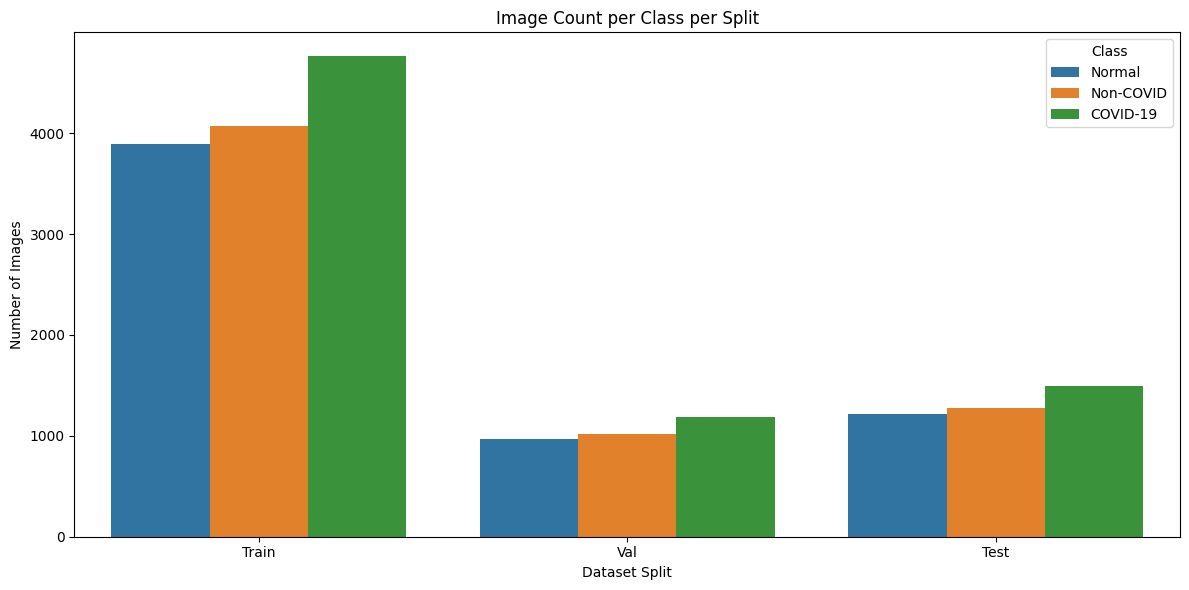

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_all, x='Split', y='Images', hue='Class', ci=None)
plt.title('Image Count per Class per Split')
plt.ylabel('Number of Images')
plt.xlabel('Dataset Split')
plt.legend(title='Class')
plt.tight_layout()
plt.show()


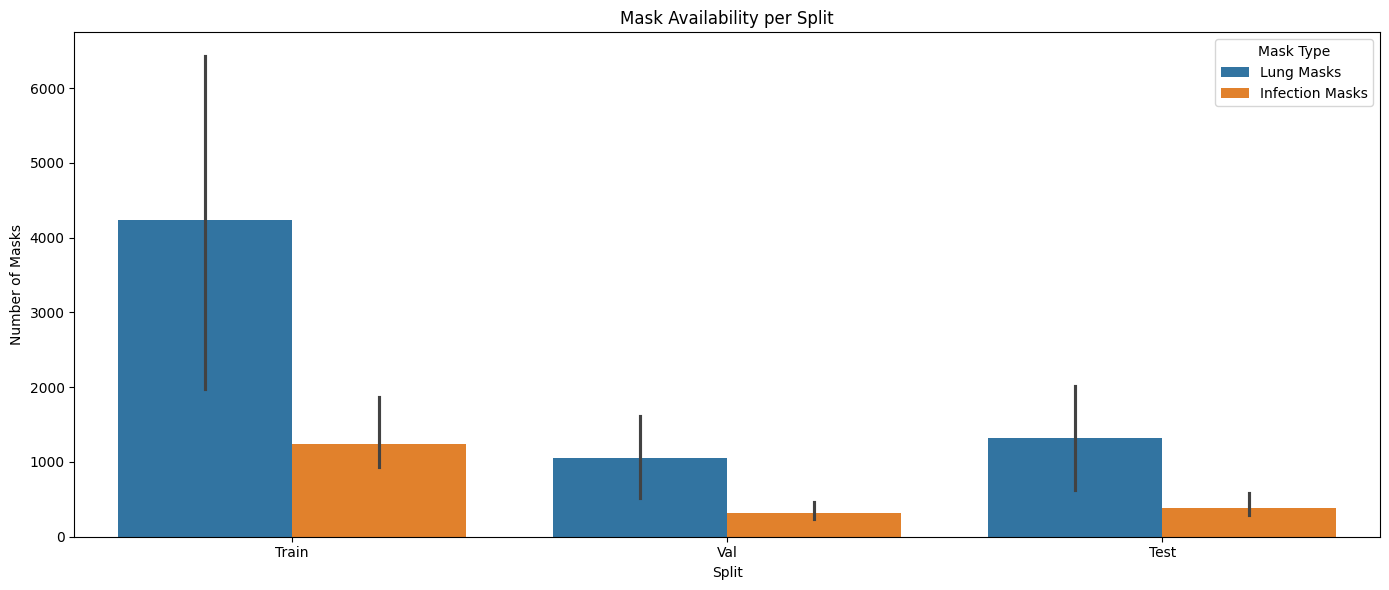

In [15]:
melted = df_all.melt(id_vars=['Dataset', 'Split', 'Class'], value_vars=['Lung Masks', 'Infection Masks'])
plt.figure(figsize=(14, 6))
sns.barplot(data=melted, x='Split', y='value', hue='variable')
plt.title('Mask Availability per Split')
plt.ylabel('Number of Masks')
plt.xlabel('Split')
plt.legend(title='Mask Type')
plt.tight_layout()
plt.show()


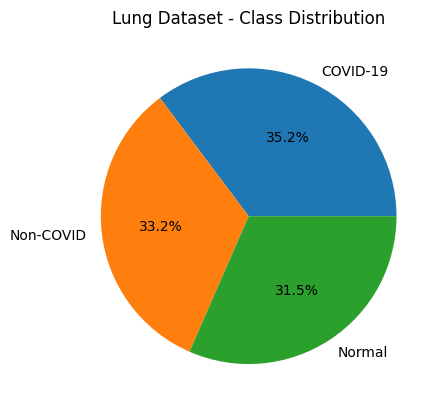

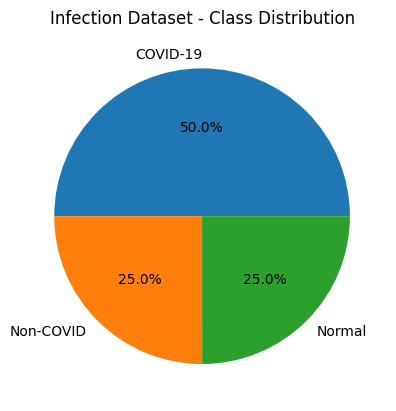

In [16]:
for dataset in ['Lung', 'Infection']:
    subset = df_all[df_all['Dataset'] == dataset]
    class_counts = subset.groupby('Class')['Images'].sum()
    plt.figure()
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
    plt.title(f'{dataset} Dataset - Class Distribution')
    plt.show()


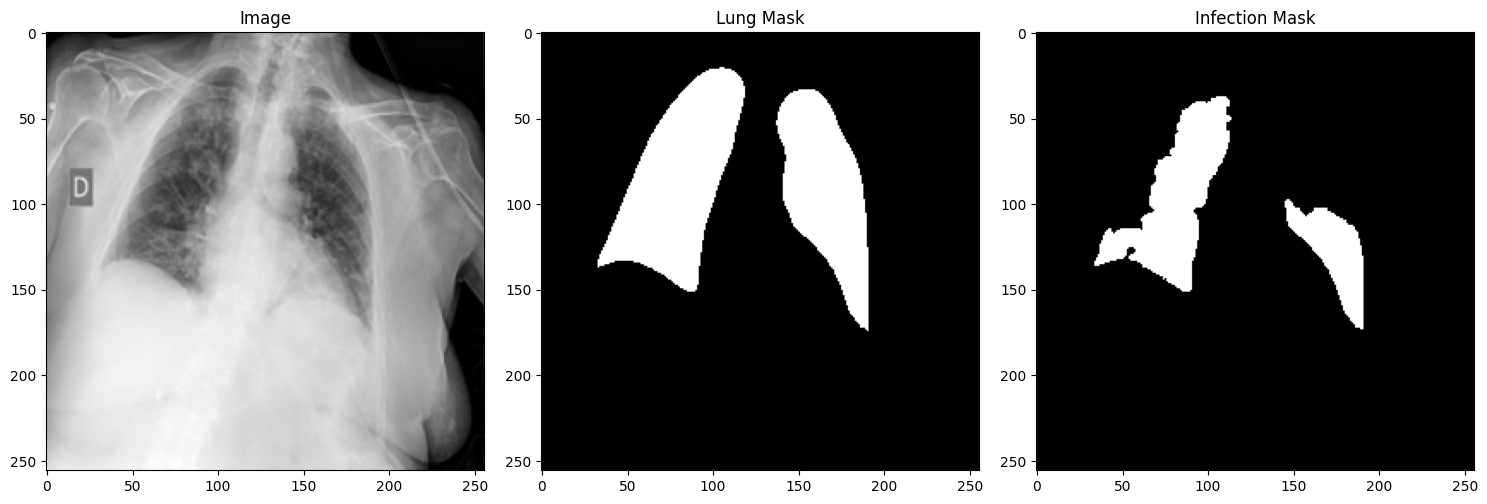

In [17]:
import cv2
import numpy as np

def visualize_sample(image_path, lung_mask_path=None, infection_mask_path=None):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')

    if lung_mask_path:
        lung_mask = cv2.imread(lung_mask_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 3, 2)
        plt.imshow(lung_mask, cmap='gray')
        plt.title('Lung Mask')

    if infection_mask_path:
        infection_mask = cv2.imread(infection_mask_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 3, 3)
        plt.imshow(infection_mask, cmap='gray')
        plt.title('Infection Mask')

    plt.tight_layout()
    plt.show()

# Example usage (adjust the paths):
visualize_sample(
    'covidqu_data/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images/covid_4017.png',
    'covidqu_data/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/lung masks/covid_4017.png',
    'covidqu_data/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/infection masks/covid_4017.png'
)

In [18]:
import os
import cv2
import numpy as np
import pandas as pd
from collections import defaultdict

# First, let's verify our merged_df structure
print("Checking merged dataframe structure...")
print(f"Total rows in merged_df: {len(merged_df)}")
print("Columns in merged_df:", merged_df.columns.tolist())
print("\nFirst few rows:")
print(merged_df.head())

# Check if paths exist
def check_paths_exist(df):
    path_columns = ['path_original', 'path_lung_mask', 'infection_mask_path']
    results = defaultdict(int)

    for col in path_columns:
        exists = df[col].apply(lambda x: os.path.exists(x) if isinstance(x, str) else False)
        results[f"{col}_exists"] = exists.sum()
        results[f"{col}_missing"] = len(df) - exists.sum()

    return results

path_stats = check_paths_exist(merged_df)
print("\nPath existence statistics:")
for k, v in path_stats.items():
    print(f"{k}: {v}")

# Let's create a function to properly build our dataset
def build_correct_dataset(lung_base, infection_base):
    data = []

    for subset in ['Train', 'Test', 'Val']:
        for class_name in ['COVID-19', 'Non-COVID', 'Normal']:
            # Paths for original images
            img_dir = os.path.join(lung_base, subset, class_name, 'images')
            if not os.path.exists(img_dir):
                print(f"Missing directory: {img_dir}")
                continue

            # Get all image files
            for img_file in os.listdir(img_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    base_name = os.path.splitext(img_file)[0]

                    # Construct all paths
                    original_path = os.path.join(img_dir, img_file)
                    lung_mask_path = os.path.join(lung_base, subset, class_name, 'lung masks', f"{base_name}.png")
                    infection_mask_path = os.path.join(infection_base, subset, class_name, 'infection masks', f"{base_name}.png")

                    # Only add if all files exist
                    if all(os.path.exists(p) for p in [original_path, lung_mask_path, infection_mask_path]):
                        data.append({
                            'subset': subset,
                            'class': class_name,
                            'original_path': original_path,
                            'lung_mask_path': lung_mask_path,
                            'infection_mask_path': infection_mask_path
                        })
                    else:
                        missing = [p for p in [original_path, lung_mask_path, infection_mask_path] if not os.path.exists(p)]
                        print(f"Missing files for {base_name}: {missing}")

    return pd.DataFrame(data)

print("\nBuilding corrected dataset...")
corrected_df = build_correct_dataset(lung_base, infection_base)
print(f"Found {len(corrected_df)} complete samples")

if len(corrected_df) > 0:
    print("\nSample paths from corrected dataset:")
    print(corrected_df.head())

    # Now calculate severity scores
    def calculate_severity(row):
        try:
            lung_mask = cv2.imread(row['lung_mask_path'], cv2.IMREAD_GRAYSCALE)
            infection_mask = cv2.imread(row['infection_mask_path'], cv2.IMREAD_GRAYSCALE)

            if lung_mask is None or infection_mask is None:
                return np.nan

            lung_area = np.sum(lung_mask > 127)
            infection_area = np.sum(infection_mask > 127)

            return (infection_area / lung_area) * 100 if lung_area > 0 else 0
        except Exception as e:
            print(f"Error calculating severity for {row['original_path']}: {str(e)}")
            return np.nan

    corrected_df['severity'] = corrected_df.apply(calculate_severity, axis=1)
    corrected_df = corrected_df.dropna(subset=['severity'])

    print("\nSeverity statistics:")
    print(corrected_df['severity'].describe())

    # Save the corrected dataframe
    corrected_df.to_pickle('corrected_covid_dataset.pkl')
    print("\nSaved corrected dataset to 'corrected_covid_dataset.pkl'")
else:
    print("\nNo valid samples found. Please check your dataset paths and structure.")

Streaming output truncated to the last 5000 lines.
Missing files for Normal (9101): ['covidqu_data/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/infection masks/Normal (9101).png']
Missing files for Normal (9254): ['covidqu_data/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/infection masks/Normal (9254).png']
Missing files for Normal (8475): ['covidqu_data/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/infection masks/Normal (8475).png']
Missing files for Normal (521): ['covidqu_data/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/infection masks/Normal (521).png']
Missing files for Normal (582): ['covidqu_data/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/infection masks/Normal (582).png']
Missing files for Normal (9193): ['covidqu_data/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/infection masks/Normal (9193).png']
Missing files for Normal (309): ['covidqu

In [19]:
# Quick path verification test
test_path = 'covidqu_data/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images'
print(f"Test path exists: {os.path.exists(test_path)}")
print(f"Contents of COVID-19 train images: {os.listdir(test_path)[:5] if os.path.exists(test_path) else 'Path not found'}")

Test path exists: True
Contents of COVID-19 train images: ['covid_4257.png', 'covid_4387.png', 'covid_1522.png', 'covid_820.png', 'covid_3818.png']


In [20]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

# Define paths
base_path = 'covidqu_data'
lung_base = os.path.join(base_path, 'Lung Segmentation Data', 'Lung Segmentation Data')
infection_base = os.path.join(base_path, 'Infection Segmentation Data', 'Infection Segmentation Data')

def build_verified_dataset():
    samples = []

    # Iterate through all subsets and classes
    for subset in ['Train', 'Test', 'Val']:
        for class_name in ['COVID-19', 'Non-COVID', 'Normal']:
            # Path to original images
            img_dir = os.path.join(lung_base, subset, class_name, 'images')

            # Skip if directory doesn't exist
            if not os.path.exists(img_dir):
                print(f"Warning: Missing directory - {img_dir}")
                continue

            # Get all image files
            image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            # Track found/missing files
            found = 0
            missing = 0

            for img_file in tqdm(image_files, desc=f"{subset}/{class_name}"):
                base_name = os.path.splitext(img_file)[0]

                # Construct all required paths
                original_path = os.path.join(img_dir, img_file)
                lung_mask_path = os.path.join(lung_base, subset, class_name, 'lung masks', f"{base_name}.png")
                infection_mask_path = os.path.join(infection_base, subset, class_name, 'infection masks', f"{base_name}.png")

                # Verify all files exist
                if all(os.path.exists(p) for p in [original_path, lung_mask_path, infection_mask_path]):
                    samples.append({
                        'subset': subset,
                        'class': class_name,
                        'original_path': original_path,
                        'lung_mask_path': lung_mask_path,
                        'infection_mask_path': infection_mask_path
                    })
                    found += 1
                else:
                    missing += 1

            print(f"{subset}/{class_name}: Found {found} complete samples, {missing} incomplete")

    return pd.DataFrame(samples)

print("Building verified dataset...")
verified_df = build_verified_dataset()

if len(verified_df) > 0:
    print(f"\nSuccessfully loaded {len(verified_df)} complete samples")
    print("\nSample records:")
    print(verified_df.head())

    # Save the verified dataset
    verified_df.to_pickle('verified_covid_dataset.pkl')
    print("\nSaved verified dataset to 'verified_covid_dataset.pkl'")

    # Show distribution
    print("\nClass distribution:")
    print(verified_df['class'].value_counts())

    print("\nSubset distribution:")
    print(verified_df['subset'].value_counts())
else:
    print("\nNo complete samples found. Please check the dataset structure.")

Building verified dataset...


Train/COVID-19: 100%|██████████| 7658/7658 [00:00<00:00, 38282.83it/s]


Train/COVID-19: Found 1864 complete samples, 5794 incomplete


Train/Non-COVID: 100%|██████████| 7208/7208 [00:00<00:00, 37080.86it/s]


Train/Non-COVID: Found 932 complete samples, 6276 incomplete


Train/Normal: 100%|██████████| 6849/6849 [00:00<00:00, 39311.16it/s]


Train/Normal: Found 932 complete samples, 5917 incomplete


Test/COVID-19: 100%|██████████| 2395/2395 [00:00<00:00, 39159.37it/s]


Test/COVID-19: Found 583 complete samples, 1812 incomplete


Test/Non-COVID: 100%|██████████| 2253/2253 [00:00<00:00, 40617.60it/s]


Test/Non-COVID: Found 292 complete samples, 1961 incomplete


Test/Normal: 100%|██████████| 2140/2140 [00:00<00:00, 41443.01it/s]


Test/Normal: Found 291 complete samples, 1849 incomplete


Val/COVID-19: 100%|██████████| 1903/1903 [00:00<00:00, 40364.31it/s]


Val/COVID-19: Found 466 complete samples, 1437 incomplete


Val/Non-COVID: 100%|██████████| 1802/1802 [00:00<00:00, 38882.30it/s]


Val/Non-COVID: Found 233 complete samples, 1569 incomplete


Val/Normal: 100%|██████████| 1712/1712 [00:00<00:00, 36692.12it/s]

Val/Normal: Found 233 complete samples, 1479 incomplete

Successfully loaded 5826 complete samples

Sample records:
  subset     class                                      original_path  \
0  Train  COVID-19  covidqu_data/Lung Segmentation Data/Lung Segme...   
1  Train  COVID-19  covidqu_data/Lung Segmentation Data/Lung Segme...   
2  Train  COVID-19  covidqu_data/Lung Segmentation Data/Lung Segme...   
3  Train  COVID-19  covidqu_data/Lung Segmentation Data/Lung Segme...   
4  Train  COVID-19  covidqu_data/Lung Segmentation Data/Lung Segme...   

                                      lung_mask_path  \
0  covidqu_data/Lung Segmentation Data/Lung Segme...   
1  covidqu_data/Lung Segmentation Data/Lung Segme...   
2  covidqu_data/Lung Segmentation Data/Lung Segme...   
3  covidqu_data/Lung Segmentation Data/Lung Segme...   
4  covidqu_data/Lung Segmentation Data/Lung Segme...   

                                 infection_mask_path  
0  covidqu_data/Infection Segmentation Data/Infec... 

In [21]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 1. Calculate severity scores
def calculate_severity(row):
    lung_mask = cv2.imread(row['lung_mask_path'], cv2.IMREAD_GRAYSCALE)
    infection_mask = cv2.imread(row['infection_mask_path'], cv2.IMREAD_GRAYSCALE)

    lung_area = np.sum(lung_mask > 127)
    infection_area = np.sum(infection_mask > 127)

    return (infection_area / lung_area) * 100 if lung_area > 0 else 0

print("Calculating severity scores...")
verified_df['severity'] = verified_df.apply(calculate_severity, axis=1)

# 2. Create severity categories
bins = [0, 10, 25, 50, 100]
labels = ['mild', 'moderate', 'severe', 'critical']
verified_df['severity_category'] = pd.cut(verified_df['severity'], bins=bins, labels=labels)

# 3. Show severity distribution
print("\nSeverity distribution:")
print(verified_df['severity_category'].value_counts())

# 4. Prepare data splits (maintaining original splits)
train_df = verified_df[verified_df['subset'] == 'Train']
val_df = verified_df[verified_df['subset'] == 'Val']
test_df = verified_df[verified_df['subset'] == 'Test']

# 5. Save processed datasets
train_df.to_pickle('train_dataset.pkl')
val_df.to_pickle('val_dataset.pkl')
test_df.to_pickle('test_dataset.pkl')

print("\nData preparation complete!")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Calculating severity scores...

Severity distribution:
severity_category
critical    1478
severe       711
moderate     476
mild         248
Name: count, dtype: int64

Data preparation complete!
Training samples: 3728
Validation samples: 932
Test samples: 1166


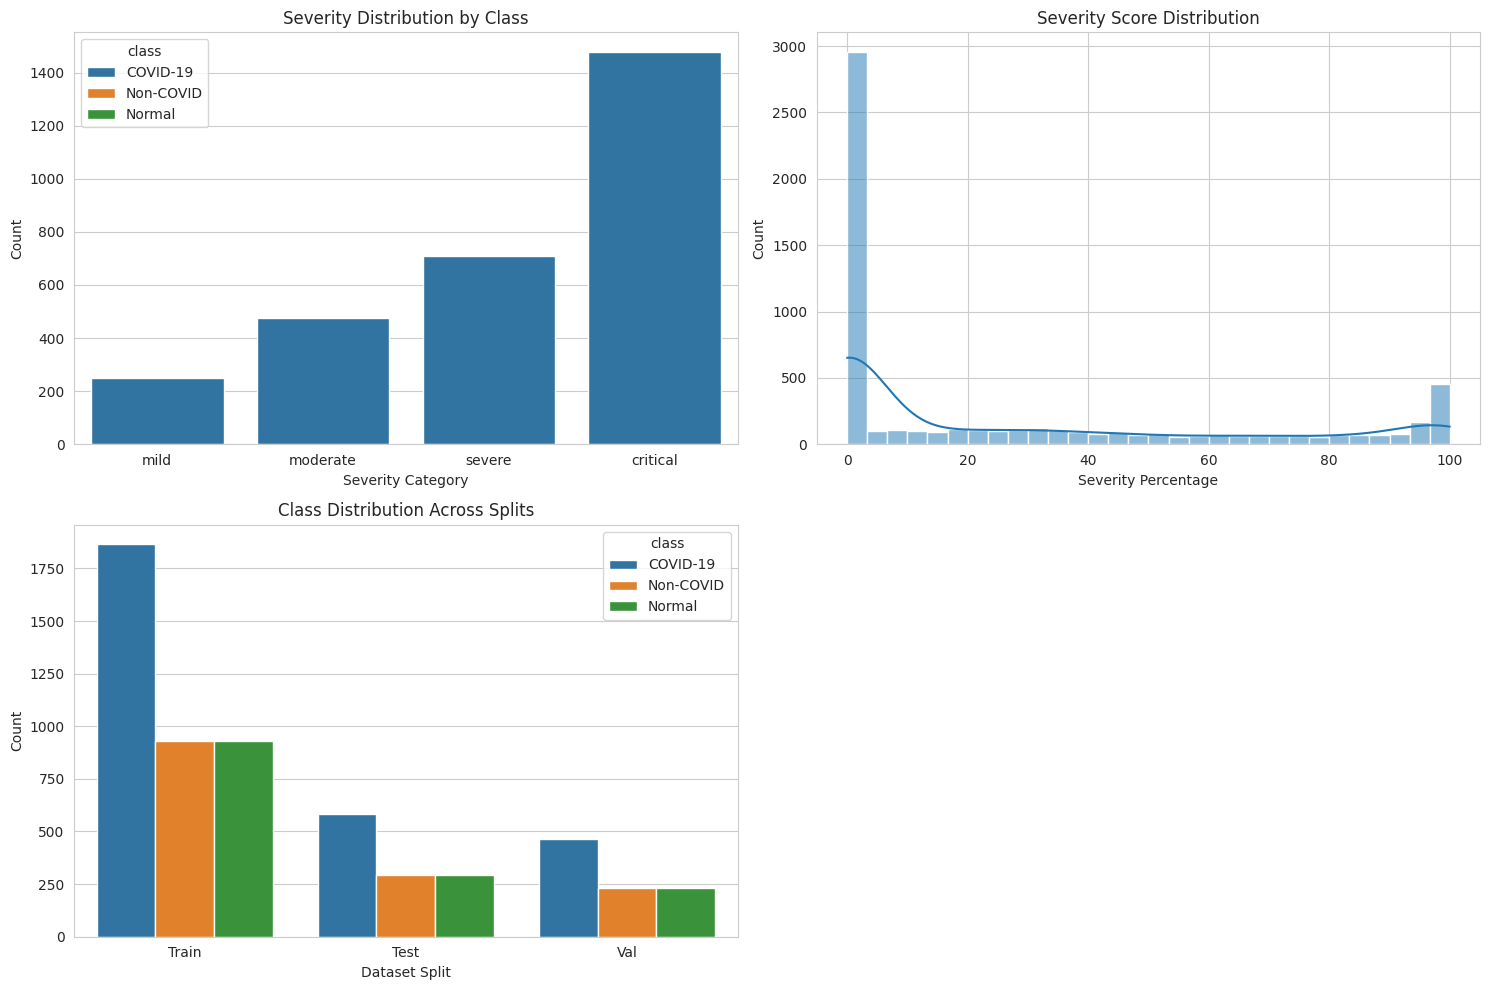


Visualizing random samples...


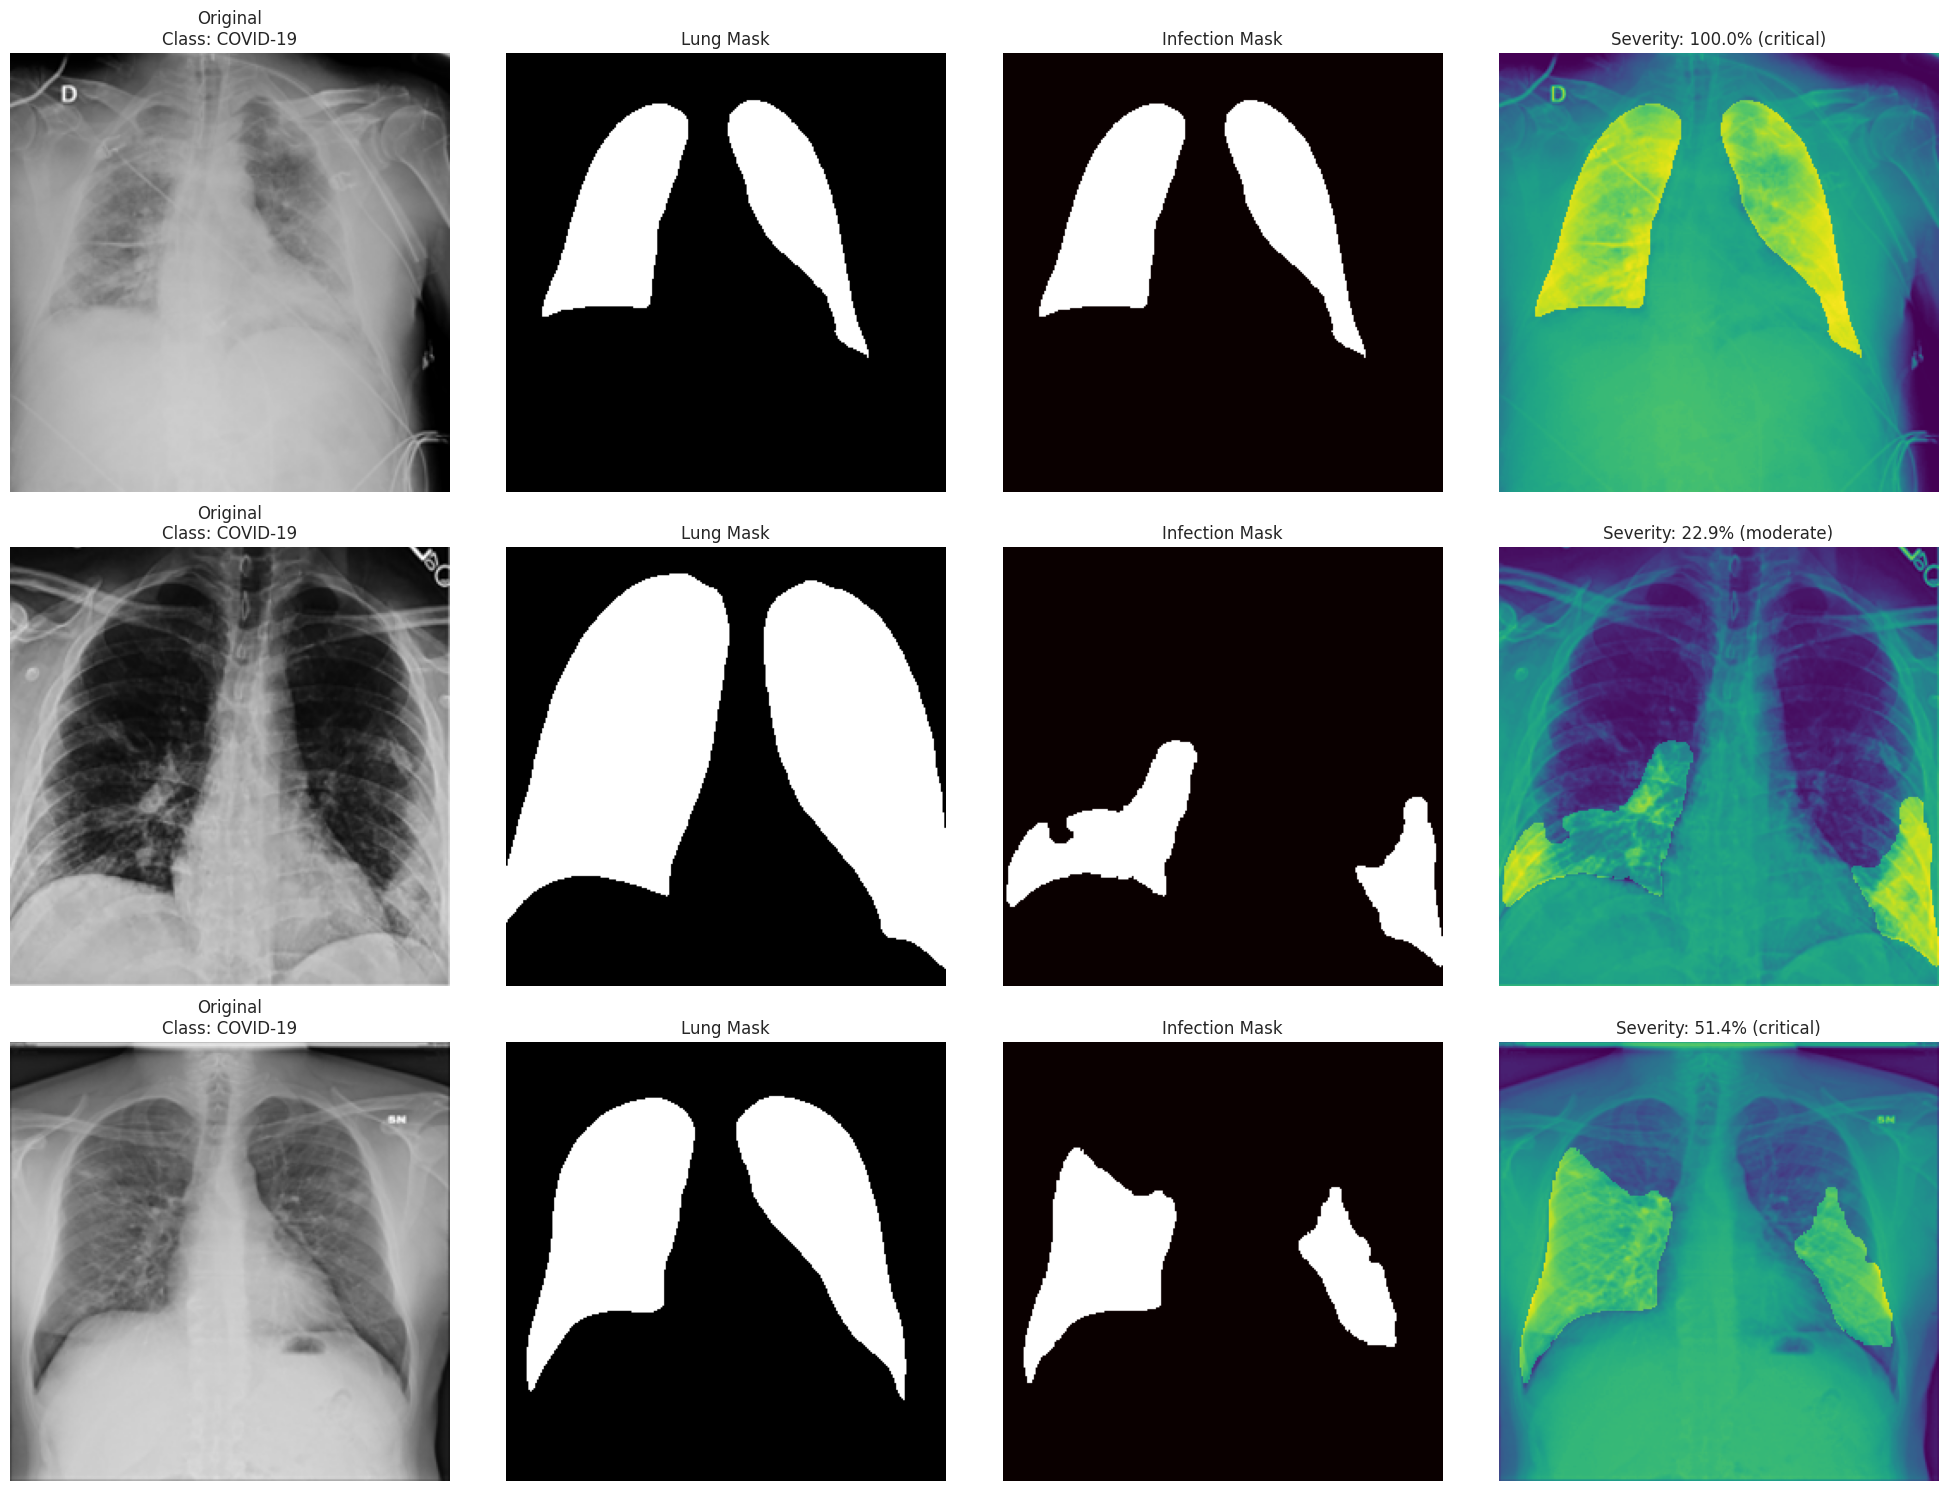

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set style
sns.set_style('whitegrid')
plt.figure(figsize=(15, 10))

# 1. Severity distribution by class
plt.subplot(2, 2, 1)
sns.countplot(data=verified_df, x='severity_category', hue='class')
plt.title('Severity Distribution by Class')
plt.xlabel('Severity Category')
plt.ylabel('Count')

# 2. Severity score distribution
plt.subplot(2, 2, 2)
sns.histplot(verified_df['severity'], bins=30, kde=True)
plt.title('Severity Score Distribution')
plt.xlabel('Severity Percentage')

# 3. Class distribution across splits
plt.subplot(2, 2, 3)
sns.countplot(data=verified_df, x='subset', hue='class')
plt.title('Class Distribution Across Splits')
plt.xlabel('Dataset Split')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# 4. Visualize random samples with masks and severity
def visualize_random_samples(df, n_samples=3):
    fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5*n_samples))

    for i in range(n_samples):
        sample = df.sample(1).iloc[0]

        # Load images
        img = cv2.cvtColor(cv2.imread(sample['original_path']), cv2.COLOR_BGR2RGB)
        lung_mask = cv2.imread(sample['lung_mask_path'], cv2.IMREAD_GRAYSCALE)
        infection_mask = cv2.imread(sample['infection_mask_path'], cv2.IMREAD_GRAYSCALE)

        # Original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original\nClass: {sample['class']}")
        axes[i, 0].axis('off')

        # Lung mask
        axes[i, 1].imshow(lung_mask, cmap='gray')
        axes[i, 1].set_title("Lung Mask")
        axes[i, 1].axis('off')

        # Infection mask
        axes[i, 2].imshow(infection_mask, cmap='hot')
        axes[i, 2].set_title("Infection Mask")
        axes[i, 2].axis('off')

        # Combined
        overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 0.7, infection_mask, 0.3, 0)
        axes[i, 3].imshow(overlay, cmap='viridis')
        axes[i, 3].set_title(f"Severity: {sample['severity']:.1f}% ({sample['severity_category']})")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing random samples...")
visualize_random_samples(verified_df)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def create_data_generator(df, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_dataframe(
        dataframe=df,
        x_col='original_path',
        y_col='severity_category',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    return generator

# Create generators
# Filter out rows where 'severity_category' is NaN before creating generators
train_df_filtered = train_df.dropna(subset=['severity_category'])
val_df_filtered = val_df.dropna(subset=['severity_category'])
test_df_filtered = test_df.dropna(subset=['severity_category'])


train_generator = create_data_generator(train_df_filtered, augment=True)
val_generator = create_data_generator(val_df_filtered)
test_generator = create_data_generator(test_df_filtered)

# Show class indices
print("\nClass indices:", train_generator.class_indices)

Found 1864 validated image filenames belonging to 4 classes.
Found 466 validated image filenames belonging to 4 classes.
Found 583 validated image filenames belonging to 4 classes.

Class indices: {'critical': 0, 'mild': 1, 'moderate': 2, 'severe': 3}


In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

def build_model(num_classes=4):
    base_model = EfficientNetB0(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model
    base_model.trainable = False

    # Add custom head
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_model()
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.5209 - loss: 1.2155

59/59 ━━━━━━━━━━━━━━━━━━━━ 25s 417ms/step - accuracy: 0.5207 - loss: 1.2156 - val_accuracy: 0.5043 - val_loss: 1.1811
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.5056 - loss: 1.1994

59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 414ms/step - accuracy: 0.5056 - loss: 1.1996 - val_accuracy: 0.5043 - val_loss: 1.1810
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 406ms/step - accuracy: 0.4942 - loss: 1.2323 - val_accuracy: 0.5043 - val_loss: 1.1940
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.5245 - loss: 1.1882

59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 412ms/step - accuracy: 0.5242 - loss: 1.1886 - val_accuracy: 0.5043 - val_loss: 1.1727
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 404ms/step - accuracy: 0.5068 - loss: 1.2051 - val_accuracy: 0.5043 - val_loss: 1.1733
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 404ms/step - accuracy: 0.5129 - loss: 1.1954 - val_accuracy: 0.5043 - val_loss: 1.1849
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 402ms/step - accuracy: 0.5077 - loss: 1.2053 - val_accuracy: 0.5043 - val_loss: 1.1839
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 402ms/step - accuracy: 0.4930 - loss: 1.2139 - val_accuracy: 0.5043 - val_loss: 1.1746
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 405ms/step - accuracy: 0.4904 - loss: 1.2211 - val_accuracy: 0.5043 - val_loss: 1.1753


In [17]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0

def build_improved_model(num_classes=4):
    # Load base model with pretrained weights
    base_model = EfficientNetB0(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # Partial unfreezing (last 10 layers)
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Enhanced architecture
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=True)  # Enable training mode for BN layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    # Custom learning rate and class weights
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    return model

model = build_improved_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 1,222,196 (4.66 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.49469214437367304), 1: np.float64(2.7904191616766467), 2: np.float64(1.5328947368421053), 3: np.float64(1.033259423503326)}


In [19]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_auc'),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_auc'),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 71s 800ms/step - accuracy: 0.2419 - auc: 0.5099 - loss: 1.4338 - precision: 0.3210 - recall: 0.0049 - val_accuracy: 0.2618 - val_auc: 0.4678 - val_loss: 1.4311 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 25s 418ms/step - accuracy: 0.2605 - auc: 0.5227 - loss: 1.4147 - precision: 0.1525 - recall: 0.0013 - val_accuracy: 0.2618 - val_auc: 0.4151 - val_loss: 1.4282 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 25s 416ms/step - accuracy: 0.2611 - auc: 0.5602 - loss: 1.3997 - precision: 0.1517 - recall: 7.3131e-04 - val_accuracy: 0.0601 - val_auc: 0.2915 - val_loss: 1.4362 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 25s 419ms/step - accuracy: 0.2320 - auc: 0.4841 - loss: 1.4074 - precision: 0.3303 - recall: 0.0033 - val_accuracy: 0.060

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.0979 - auc: 0.2768 - loss: 1.4204 - precision: 0.0000e+00 - recall: 0.0000e+00
Test Accuracy: 9.09%
Test AUC: 28.75%
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 431ms/step


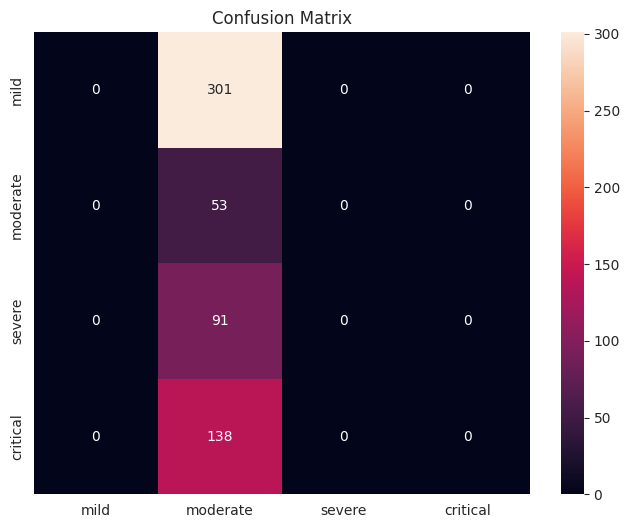

In [20]:
# Load best model
model = tf.keras.models.load_model('best_model.keras')

# Evaluate
test_results = model.evaluate(test_generator)
print(f"Test Accuracy: {test_results[1]:.2%}")
print(f"Test AUC: {test_results[2]:.2%}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.show()

In [24]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

# 1. Prepare binary dataset
binary_df = verified_df.copy()
binary_df['is_covid'] = (binary_df['class'] == 'COVID-19').astype(int)

# 2. Create balanced generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=binary_df[binary_df['subset']=='Train'],
    x_col='original_path',
    y_col='is_covid',
    class_mode='raw',
    target_size=(224,224),
    batch_size=32,
    shuffle=True
)

# 3. Train DenseNet121 binary classifier
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy', AUC()])
model.fit(train_generator, epochs=15)

Found 3728 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.8821 - auc: 0.9546 - loss: 0.2448
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 58s 492ms/step - accuracy: 0.9765 - auc: 0.9971 - loss: 0.0622
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 57s 488ms/step - accuracy: 0.9915 - auc: 0.9991 - loss: 0.0285
Epoch 4/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 58s 491ms/step - accuracy: 0.9911 - auc: 0.9998 - loss: 0.0208
Epoch 5/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 58s 494ms/step - accuracy: 0.9907 - auc: 0.9992 - loss: 0.0264
Epoch 6/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 58s 492ms/step - accuracy: 0.9964 - auc: 0.9996 - loss: 0.0142
Epoch 7/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 57s 488ms/step - accuracy: 0.9964 - auc: 0.9999 - loss: 0.0143
Epoch 8/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 57s 485ms/step - accuracy: 0.9963 - auc: 0.9999 - loss: 0.0101
Epoch 9/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 58s 496ms/step - accuracy: 0.9967 - auc: 0.9999 - loss: 0.0089
Epoch 10/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 57s 487ms/step - accuracy: 0.9952 

In [25]:
model.save('/content/drive/MyDrive/covid_binary_model.h5')

In [26]:
# 1. Filter COVID cases
covid_df = verified_df[verified_df['class']=='COVID-19'].copy()

# 2. Create severity generator
severity_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=covid_df,
    x_col='original_path',
    y_col='severity',  # Continuous value
    class_mode='raw',
    target_size=(224,224),
    batch_size=16
)

# 3. Train regression model
severity_model = Sequential([
    DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3)),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1)  # Linear output for severity %
])
severity_model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
severity_model.fit(severity_generator, epochs=20)

Found 2913 validated image filenames.
Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 269s 602ms/step - loss: 2287.1714 - mae: 38.2834
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 89s 161ms/step - loss: 265.8299 - mae: 12.2069
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - loss: 197.0290 - mae: 10.8542
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 159ms/step - loss: 165.3740 - mae: 9.8953
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - loss: 118.1279 - mae: 8.3968
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 162ms/step - loss: 90.0766 - mae: 7.4376
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - loss: 94.8587 - mae: 7.5529
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 159ms/step - loss: 74.9151 - mae: 6.6829
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - loss: 82.9627 - mae: 7.0728
Epoch 10/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 159ms/step - loss: 56.4399 - mae: 5.8983
Epoch 11/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - loss: 45.9112 - mae: 5.1988
Epoch 12/20
183

In [27]:
severity_model.save('/content/drive/MyDrive/severity_regression_model.h5')

In [30]:
# Evaluate COVID detector
test_generator = train_datagen.flow_from_dataframe(
    dataframe=binary_df[binary_df['subset']=='Test'],
    x_col='original_path',
    y_col='is_covid',
    class_mode='raw',
    target_size=(224,224),
    batch_size=32,
    shuffle=False
)

loss, acc, auc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.1%}, AUC: {auc:.1%}")

Found 1166 validated image filenames.
37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 732ms/step - accuracy: 0.9646 - auc: 0.5222 - loss: 0.1004
Test Accuracy: 91.0%, AUC: 99.4%


37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 698ms/step
Test Accuracy: 91.9%

Classification Report:
              precision    recall  f1-score   support

   Non-COVID       1.00      0.84      0.91       583
       COVID       0.86      1.00      0.92       583

    accuracy                           0.92      1166
   macro avg       0.93      0.92      0.92      1166
weighted avg       0.93      0.92      0.92      1166



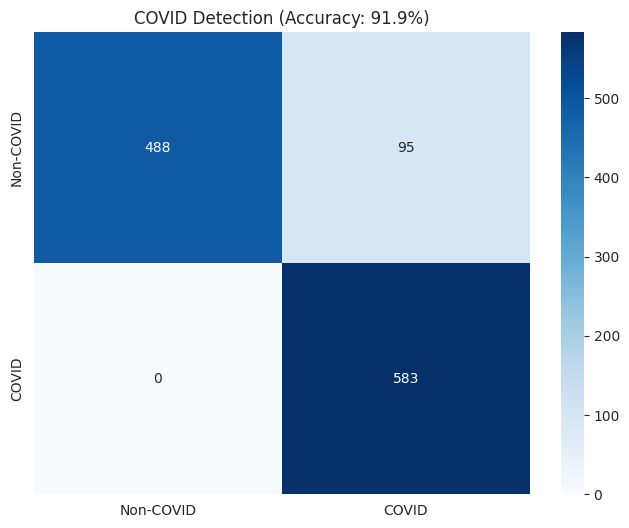

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get true labels and predictions
test_generator.reset()  # Important for correct label order
y_true = test_generator.labels
y_pred = (model.predict(test_generator) > 0.5).astype(int).flatten()

# 2. Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.1%}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-COVID', 'COVID']))

# 3. Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-COVID', 'COVID'],
            yticklabels=['Non-COVID', 'COVID'])
plt.title(f'COVID Detection (Accuracy: {accuracy:.1%})')
plt.show()

Found 1864 validated image filenames belonging to 4 classes.
Found 466 validated image filenames belonging to 4 classes.
Found 583 validated image filenames belonging to 4 classes.
Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 75s 461ms/step - accuracy: 0.4098 - loss: 1.5391 - val_accuracy: 0.5323 - val_loss: 1.1017
Epoch 2/30
  1/116 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5625 - loss: 1.2690

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5625 - loss: 1.2690 - val_accuracy: 0.5323 - val_loss: 1.1022
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 246ms/step - accuracy: 0.4920 - loss: 1.2055 - val_accuracy: 0.5625 - val_loss: 1.0318
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5625 - loss: 1.1991 - val_accuracy: 0.5625 - val_loss: 1.0313
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.5491 - loss: 1.0536 - val_accuracy: 0.5690 - val_loss: 0.9985
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4375 - loss: 1.2785 - val_accuracy: 0.5711 - val_loss: 0.9989
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 30s 256ms/step - accuracy: 0.5517 - loss: 1.0624 - val_accuracy: 0.5754 - val_loss: 0.9769
Epoch 8/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4375 - loss: 0.9365 - val_accuracy: 0.5754 - val_loss: 0.9762
Epoch 9/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 28s 243ms/step - accuracy: 0.5476 - loss: 1.0376 - val_accurac

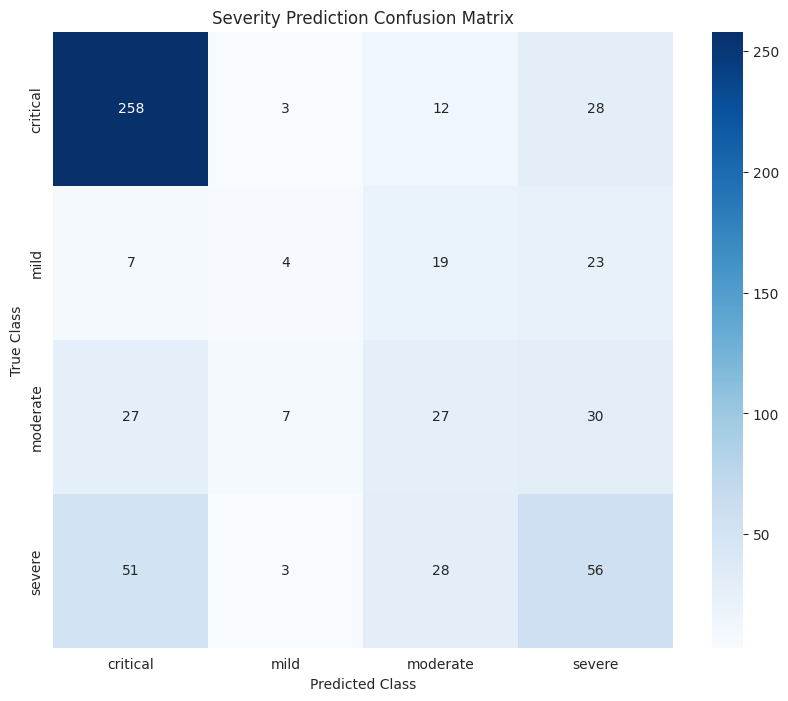

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet121
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split # You might need this later for stratified splitting
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming 'covid_df' is already loaded and contains 'original_path', 'subset', and 'severity_category'
# Make sure the 'severity_category' column exists and has the correct values (e.g., 'mild', 'moderate', 'severe', 'critical')
# Ensure 'covid_df' only contains rows for COVID-19 cases if this model is specifically for severity.

# Convert the 'severity_category' column to string type
covid_df['severity_category'] = covid_df['severity_category'].astype(str)

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = len(covid_df['severity_category'].unique()) # Get the number of unique categories

# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Only rescaling for validation and testing
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
# Filter out rows where 'severity_category' is NaN
train_df_filtered = covid_df[(covid_df['subset'] == 'Train') & covid_df['severity_category'].notna()]
val_df_filtered = covid_df[(covid_df['subset'] == 'Val') & covid_df['severity_category'].notna()]
test_df_filtered = covid_df[(covid_df['subset'] == 'Test') & covid_df['severity_category'].notna()]


train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df_filtered,
    x_col='original_path',
    y_col='severity_category',
    class_mode='categorical', # Use categorical for string labels -> one-hot encoding
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df_filtered,
    x_col='original_path',
    y_col='severity_category',
    class_mode='categorical', # Use categorical for string labels -> one-hot encoding
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df_filtered,
    x_col='original_path',
    y_col='severity_category',
    class_mode='categorical', # Use categorical for string labels -> one-hot encoding
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


# Get the class indices from the training generator to ensure consistency
# and map integer predictions back to category names.
class_indices = train_gen.class_indices
# Create a mapping from index to class name
idx_to_class = {v: k for k, v in class_indices.items()}
# Ensure the labels list matches the order of class indices for classification report
sorted_labels = [idx_to_class[i] for i in sorted(idx_to_class.keys())]


# Define the model architecture
def build_severity_model(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    # Keep the base model frozen for initial training, then unfreeze later if needed
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Output units equal to number of classes
    ])

    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='categorical_crossentropy', # Use categorical_crossentropy for one-hot encoded labels
        metrics=['accuracy']
    )
    return model

# Build the model
severity_model = build_severity_model(NUM_CLASSES)

# Train the model
print("Starting model training...")
history = severity_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE, # Calculate steps per epoch
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE, # Calculate validation steps
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_severity_model.keras', save_best_only=True, monitor='val_accuracy')
    ]
)
print("Model training finished.")

# Load the best model
# severity_model = tf.keras.models.load_model('best_severity_model.keras')

# Evaluate the model
print("\nEvaluating the model on the test set...")
# Reset test generator to ensure correct order for evaluation
test_gen.reset()
eval_results = severity_model.evaluate(test_gen, steps=test_gen.samples // BATCH_SIZE)

print(f"Test Loss: {eval_results[0]:.4f}")
print(f"Test Accuracy: {eval_results[1]:.2%}")

# Generate classification report and confusion matrix
print("\nGenerating Classification Report and Confusion Matrix...")
# Predict probabilities for the test set
test_gen.reset() # Reset again before prediction
y_pred_probs = severity_model.predict(test_gen, steps=test_gen.samples // BATCH_SIZE + 1) # Add 1 to steps to ensure all samples are included

# Get true labels and predicted labels (integer indices)
y_true_indices = test_gen.classes
y_pred_indices = np.argmax(y_pred_probs, axis=1)

# Trim predicted indices to match the number of true labels
# This is necessary because the last batch from the generator might be smaller
# than the batch size, and predict might return more predictions than samples if steps is not exact.
y_pred_indices = y_pred_indices[:len(y_true_indices)]


print("\nClassification Report:")
print(classification_report(y_true_indices, y_pred_indices, target_names=sorted_labels))

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true_indices, y_pred_indices),
            annot=True, fmt='d',
            xticklabels=sorted_labels,
            yticklabels=sorted_labels,
            cmap='Blues')
plt.title('Severity Prediction Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [38]:
checkpoint_path = '/content/drive/MyDrive/best_severity_model.keras'

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy')
]

In [39]:
history = severity_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 31s 262ms/step - accuracy: 0.5862 - loss: 0.9727 - val_accuracy: 0.5862 - val_loss: 0.9515
Epoch 2/30
  1/116 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6250 - loss: 0.9097

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6250 - loss: 0.9097 - val_accuracy: 0.5884 - val_loss: 0.9503
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 35s 241ms/step - accuracy: 0.5677 - loss: 0.9978 - val_accuracy: 0.5927 - val_loss: 0.9662
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8125 - loss: 0.7022 - val_accuracy: 0.5970 - val_loss: 0.9650
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 344ms/step - accuracy: 0.5769 - loss: 0.9465 - val_accuracy: 0.5841 - val_loss: 0.9449
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8750 - loss: 0.5678 - val_accuracy: 0.5862 - val_loss: 0.9448
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 28s 241ms/step - accuracy: 0.5805 - loss: 0.9576 - val_accuracy: 0.6034 - val_loss: 0.9417
Epoch 8/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8750 - loss: 0.6654 - val_accuracy: 0.6056 - val_loss: 0.9415
Epoch 9/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 27s 230ms/step - accuracy: 0.5950 - loss: 0.9216 - val_accurac